# Imporing Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import warnings
warnings.simplefilter(action='ignore')

# Backtesting Script

In [2]:
def extract_position(s):
    if s.iloc[0] == 1:
        start_index = [s.index[0], *s.loc[(s == 1) & (s.shift(1) == 0)].index]
    else:
        start_index = [*s.loc[(s == 1) & (s.shift(1) == 0)].index]

    if s.iloc[-1] == 1:
        end_index = [*s.loc[(s.shift(-1) == 0) & (s == 1)].index, s.index[-1]]
    else:
        end_index = [*s.loc[(s.shift(-1) == 0) & (s == 1)].index]

    return np.array(start_index), np.array(end_index)

class BacktestResult:
    def __init__(self, df, buy_equity, sell_equity):
        self.df = df
        self.buy_equity = buy_equity
        self.sell_equity = sell_equity
        self._compute()

    def _compute(self):
        if self.df is not None:
            buy_start, buy_end = extract_position(self.df['asset_buy'])
            self.buy_start = buy_start
            self.buy_end = buy_end

            sell_start, sell_end = extract_position(self.df['asset_sell'])
            self.sell_start = sell_start
            self.sell_end = sell_end

        self.equity = self.buy_equity * self.sell_equity

    def equity_curve(self):
        return pd.DataFrame({'buy' : self.buy_equity,
                             'sell' : self.sell_equity,
                             'total' : self.equity})

def backtest(df, fee_rate):
    REQUIRED_COLUMNS = ['buy', 'close_buy', 'sell', 'close_sell']
    check = all([c in df.columns for c in REQUIRED_COLUMNS])
    assert check, f'Not all of the properties {REQUIRED_COLUMNS} exist in input dataframe'

    df['asset_buy'] = np.nan
    df['asset_sell'] = np.nan

    df['asset_buy'].loc[df['buy']] = 1
    df['asset_buy'].loc[df['close_buy']] = 0

    df['asset_sell'].loc[df['sell']] = 1
    df['asset_sell'].loc[df['close_sell']] = 0

    df['asset_buy'] = df.asset_buy.fillna(method='pad').fillna(0)
    df['asset_sell'] = df.asset_sell.fillna(method='pad').fillna(0)
    df['asset_buy'] = df['asset_buy'].shift(1)
    df['asset_sell'] = df['asset_sell'].shift(1)

    df['fee'] = 0
    buy_start, buy_end = extract_position(df['asset_buy'])
    sell_start, sell_end = extract_position(df['asset_sell'])

    df['fee'].loc[buy_start] += fee_rate
    df['fee'].loc[buy_end] += fee_rate
    df['fee'].loc[sell_start] += fee_rate
    df['fee'].loc[sell_end] += fee_rate

    df.dropna(inplace=True)

    eq_buy = (1 + ((df.c.pct_change() - df.fee) * df.asset_buy).dropna()).cumprod()
    eq_sell = (1 + ((-df.c.pct_change() - df.fee) * df.asset_sell).dropna()).cumprod()

    return BacktestResult(df, eq_buy, eq_sell)

# Strategy Class

In [3]:
from abc import abstractmethod

class Strategy:
    def __init__(self):
        pass

    @abstractmethod
    def generate(self):
        raise NotImplementedError("Must Implement 'generate' method")

class SimpleTrendFollowing(Strategy):
    def __init__(self, w_short, w_long):
        self.w_short = w_short
        self.w_long = w_long

    def generate(self, data, price_col='close'):
        df = pd.DataFrame(data[price_col], columns=[price_col])

        trend_short = data[price_col].rolling(self.w_short).mean()
        df[f'ma{self.w_short}'] = trend_short

        trend_long = data[price_col].rolling(self.w_long).mean()
        df[f'ma{self.w_long}'] = trend_long

        df.dropna(inplace=True)
        df['buy'] = (trend_short >= trend_long) & (trend_short.shift(1) < trend_long.shift(1))
        df['close_buy'] = (trend_short <= trend_long) & (trend_short.shift(1) > trend_long.shift(1))

        df['sell'] = (trend_short <= trend_long) & (trend_short.shift(1) > trend_long.shift(1))
        df['close_sell'] = (trend_short >= trend_long) & (trend_short.shift(1) < trend_long.shift(1))

        return df

# Backtesting on BTCUSDT

In [4]:
# Loading price data
df = pd.read_csv('btcusdt_5m_2022Q4.csv', index_col='c_t', parse_dates=True)

# Creating a "SimpleTrendFollowing" object
strategy = SimpleTrendFollowing(w_short=50, w_long=200)

# Generate signal for our dataset
df_res = strategy.generate(df, price_col='c')

# Backtesting generated signals
FEE_RATE = 0.0005 # 0.05%
backtest_res = backtest(df_res, fee_rate=FEE_RATE)

## Equity

In [5]:
backtest_res.equity_curve()

,buy,sell,total
c_t,,,
2022-10-01 16:45:00,1.000000,1.00000,1.000000
2022-10-01 16:50:00,1.000000,1.00000,1.000000
2022-10-01 16:55:00,1.000000,1.00000,1.000000
2022-10-01 17:00:00,1.000000,1.00000,1.000000
2022-10-01 17:05:00,1.000000,1.00000,1.000000
...,...,...,...
2023-01-01 23:35:00,0.943521,1.05626,0.996604
2023-01-01 23:40:00,0.943349,1.05626,0.996422
2023-01-01 23:45:00,0.943286,1.05626,0.996355


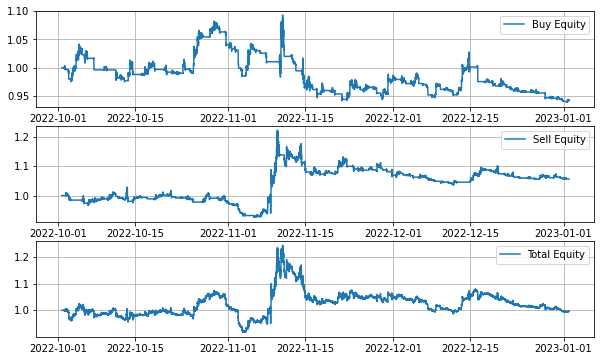

In [6]:
eq = backtest_res.equity_curve()
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))

ax1.plot(eq.buy, label='Buy Equity')
ax1.legend()
ax1.grid()

ax2.plot(eq.sell, label='Sell Equity')
ax2.legend()
ax2.grid()

ax3.plot(eq.total, label='Total Equity')
ax3.legend()
ax3.grid()

## Analysis

In [7]:
assert len(backtest_res.buy_start) == len(backtest_res.buy_end)
print(f'Number of buy positions : {len(backtest_res.buy_start)}')

assert len(backtest_res.sell_start) == len(backtest_res.sell_end)
print(f'Number of sell positions : {len(backtest_res.sell_start)}')

print(f'\nAverage duration of buy positions : {(backtest_res.buy_end - backtest_res.buy_start).mean()}')
print(f'Average duration of sell positions : {(backtest_res.sell_end - backtest_res.sell_start).mean()}')

Number of buy positions : 90
Number of sell positions : 89

Average duration of buy positions : 0 days 11:09:03.333333333
Average duration of sell positions : 0 days 13:20:53.932584269
